# N04. Proyección de oferta de energía hidráulica (ofertaEnergiaHidro)
Se realizará la proyección de 'Aportes de energía hidráulica (energía)' para los próximos 78 meses.
Esta proyección se basará en lo siguiente:

* Se encontrará la relación entre 'Aportes de energía hidráulica (energía)' y 'Aportes de energía hidráulica (caudal)'.
* Se contrará la relación y la 'Diferencia de aportes' entre los 'Aportes de energía hidráulica históricos' y 'Aportes de energía hidráulica real'.
* Se encontrará la relación entre el MEI y la 'Diferencia de aportes'.

Se crearán inicialmente dos DataFrame: 'aportes' y 'capacidad'.

## 4.1. Carga paquetes para la proyección 

In [1]:
#*******************************************************************************       
# 4.1.1. Carga paquetes requeridos para leer en base de datos y proyección.
#*******************************************************************************
import numpy as np
import pandas as pd
import datetime as dt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

import matplotlib.pyplot as plt
%matplotlib widget

import statsmodels.api as sm
import statsmodels.formula.api as smf

## 4.2. Aportes de caudales y energía de caudales
El DataFrame 'aportes' incluirá las siguientes variables, las cuales se transformarán en variables mensuales:
* AporEner
* AporEnerMediHist
* AporCaudalRio
* AporCaudalMediHistRio

* AporCaudalRio (m3/s). Valores de la hidrologia de los caudales de los rios del SIN, en metros cubicos por segundo.

* AporCaudalMediHistRio (m3/s). Caudal medio mensual histórico para los rios del SIN, obtenido como el promedio de los valores de cada mes para todos años con información disponibles.

* AporEner (kWh). Caudales en energia de los rios que aportan agua a algun embalse del SIN (Sistema).

* AporEnerRio (kWh). Caudales en energia de los rios que aportan agua a algun embalse del SIN (Río).

* AporEnerMediHist	Aportes Media Histórica Energía	Sistema

* AporEnerMediHist (kWh). Caudal medio mensual histórico en energia para los rios del SIN, obtenido como el promedio de los valores de cada mes para todos años con información disponibles (Sistema).

* AporCaudalMediHistRio (kWh). Caudal medio mensual histórico en energia para los rios del SIN, obtenido como el promedio de los valores de cada mes para todos años con información disponibles (Río).


In [4]:
#*******************************************************************************       
# 4.2.1. Crea la máquina para conectarse a la base de datos dbXm.db.
#*******************************************************************************
engine = create_engine('sqlite:///dbXm.db', echo=False)
Session = sessionmaker(bind=engine)
session = Session()

In [71]:
#*******************************************************************************       
# 4.2.2. Lee las variables de 'aportes' y ajusta.
#*******************************************************************************
tablas = ['AporEner', 'AporEnerMediHist', \
    'AporEnerRio', 'AporEnerMediHistRio', \
        'AporCaudalRio', 'AporCaudalMediHistRio']
nombresDf = ['aporEner', 'aporEnerMediHist', \
    'aporEnerRio', 'aporEnerMediHistRio', \
        'aporCaudalRio', 'aporCaudalMediHistRio']
df = {}

for i, tabla in  enumerate(tablas):
    consulta = "SELECT * FROM " + tabla
    df[nombresDf[i]] = pd.read_sql(consulta, engine, parse_dates=["Date"])
#Ajusta las columnas, los índices y los nombres de los DataFrames.
for i, nombre in  enumerate(nombresDf):
   df[nombre] = df[nombre].iloc[:, 1:] if i <= 1 else df[nombre].iloc[:, [1, 3]]
   df[nombre] = df[nombre].set_index('Date')
   df[nombre].columns = [nombre]
   df[nombre + '_m'] = df[nombre] #Crea los contenedores DataFrame mensuales.

In [72]:
#*******************************************************************************       
# 4.2.3. Agrupa los valores para obtener los valores de mensuales.
#*******************************************************************************
for i, nombre in  enumerate(nombresDf):
    if i <= 1: #Diarios, por Sistema.
        df[nombre + '_m'] = df[nombre + '_m']\
            .groupby(pd.to_datetime(df[nombre + '_m'].index)\
                .to_period('M')).mean()
    else: #Diarios, por ríos.
        df[nombre + '_m'] = df[nombre + '_m']\
            .groupby(pd.to_datetime(df[nombre + '_m'].index).\
                to_period('D')).sum()
        df[nombre + '_m'] = df[nombre + '_m']\
            .groupby((df[nombre + '_m'].index)\
                .to_timestamp().to_period('M')).mean()
    #
    df[nombre + '_m'].index = df[nombre + '_m'].index.to_timestamp()


In [117]:
#*******************************************************************************       
# 4.2.4. Integra las tablas de base de datos en un DataFrame aportes_m.
#*******************************************************************************
# # aportes_m = df['aporEner_m']/1e6
# nombresDf_m = ['aporEnerMediHist_m', \
#     'aporEnerRio_m', 'aporEnerMediHistRio_m', \
#         'aporCaudalRio_m', 'aporCaudalMediHistRio_m']
# for i, nombre in enumerate(nombresDf_m):
#     if i == 0:
#         aportes_m = pd.merge(aportes_m, df[nombre]/1e6, left_on="Date", right_on="Date")
#     else:
#         aportes_m = pd.merge(aportes_m, df[nombre], left_on="Date", right_on="Date")

# aportes_m = aportes_m.drop(columns=['aporEnerRio', 'aporEnerMediHistRio'])
# aportes_m.insert(loc=len(aportes_m.columns), column="diferenciaAportes", \
#     value=(aportes_m['aporEner'] - aportes_m['aporEnerMediHist']).values, \
#         allow_duplicates=True)

In [192]:
#*******************************************************************************
# 4.2.5. Salva  y lee aportes_m.
#*******************************************************************************
#Salva pbmCpe
# aportes_m.to_parquet('parquet/aportes_m.parquet.gzip', compression='gzip', \
#     engine='fastparquet')
#Lee pbmCpe
aportes_m = pd.read_parquet('parquet/aportes_m.parquet.gzip', \
    engine='fastparquet')

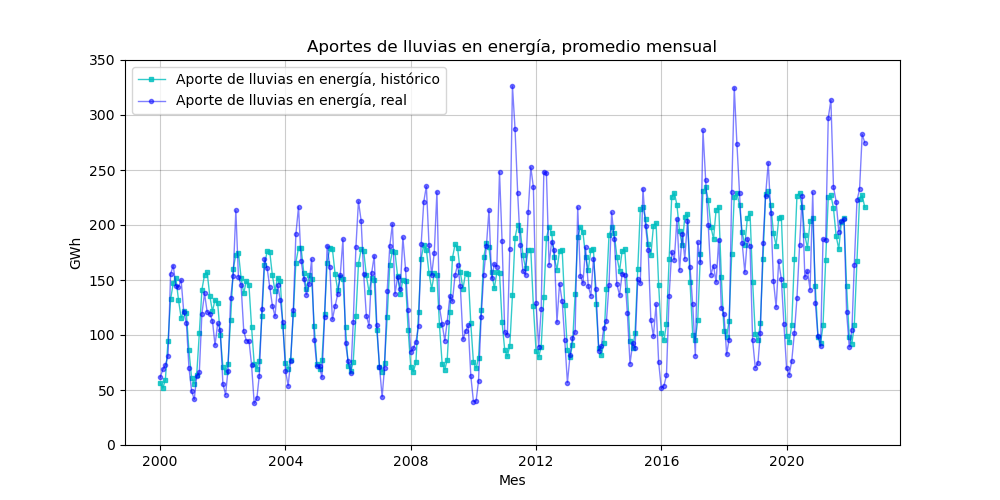

In [194]:
#*******************************************************************************
# 4.2.6. Grafica aportes_m.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de lluvias en energía, promedio mensual')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_m.index, aportes_m.aporEnerMediHist, 'c-s', \
    label='Aporte de lluvias en energía, histórico', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(aportes_m.index, aportes_m.aporEner, 'b-o', \
    label='Aporte de lluvias en energía, real', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
#plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 350)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

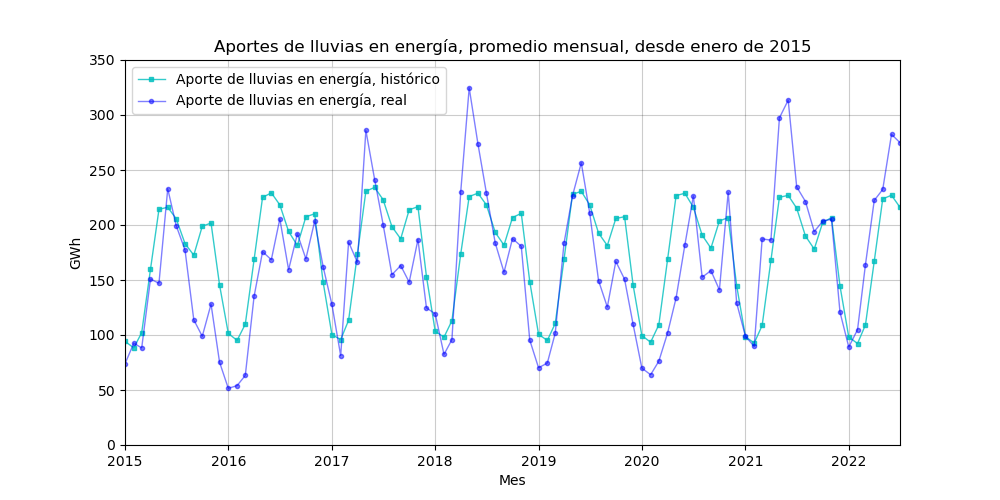

In [195]:
#*******************************************************************************
# 4.2.7. Grafica aportes_m desde 2015-01.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de lluvias en energía, promedio mensual, desde enero de 2015')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_m.index, aportes_m.aporEnerMediHist, 'c-s', \
    label='Aporte de lluvias en energía, histórico', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(aportes_m.index, aportes_m.aporEner, 'b-o', \
    label='Aporte de lluvias en energía, real', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 350)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

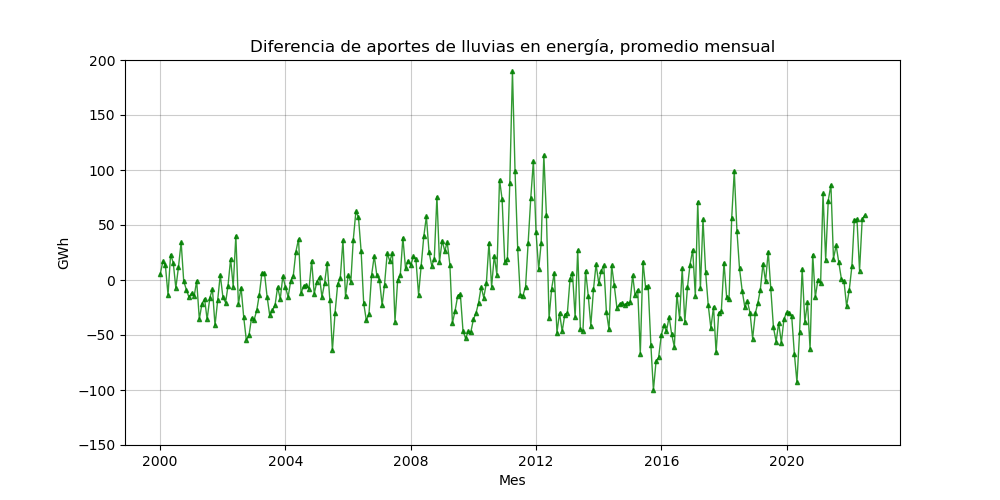

In [197]:
#*******************************************************************************
# 4.2.8. Grafica diferencia de aportes de lluvia, promedio mensual.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Diferencia de aportes de lluvias en energía, promedio mensual')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_m.index, aportes_m.diferenciaAportes, 'g-^', \
    label='Diferencia de aporte de lluvias en energía', linewidth=1, markersize=3, alpha=0.8)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
#plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(-150, 200)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

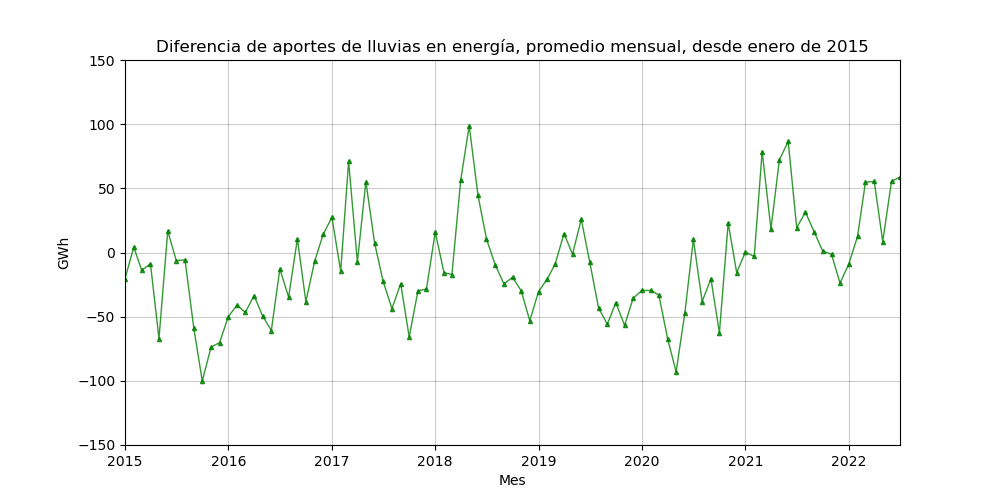

In [198]:
#*******************************************************************************
# 4.2.9. Grafica diferencia de aportes de lluvia, desde enero de 2015.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Diferencia de aportes de lluvias en energía, promedio mensual, desde enero de 2015')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_m.index, aportes_m.diferenciaAportes, 'g-^', \
    label='Diferencia de aporte de lluvias en energía', linewidth=1, markersize=3, alpha=0.8)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(-150, 150)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

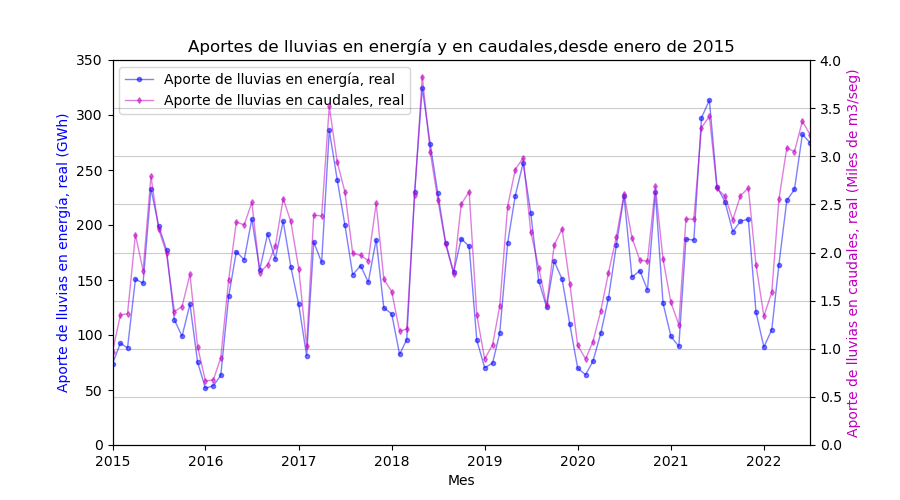

In [202]:
#*******************************************************************************
# 4.2.10. Grafica aporEner Vs aporCaudalRio desde 2015-01.
#*******************************************************************************
fig = plt.figure(figsize=(9,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
ax2 = ax1.twinx()

ax1.set_title ('Aportes de lluvias en energía y en caudales,desde enero de 2015')

ax1.set_xlabel("Mes")
ax1.set_ylabel("Aporte de lluvias en energía, real (GWh)", color='b')
ax2.set_ylabel("Aporte de lluvias en caudales, real (Miles de m3/seg)", color='m')

linea1 = ax1.plot(aportes_m.index, aportes_m.aporEner, 'b-o', \
    label="Aporte de lluvias en energía, real", \
        linewidth=1, markersize=3, alpha=0.5)

linea2 = ax2.plot(aportes_m.index, aportes_m.aporCaudalRio/1e3, 'm-d', \
    label="Aporte de lluvias en caudales, real", linewidth=1, \
        markersize=3, alpha=0.5)


# added these three lines
lineas = linea1 + linea2
etiquetas = [l.get_label() for l in lineas]
ax1.legend(lineas, etiquetas, loc='best')

plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
#plt.ylim(0, 400)
#plt.par.ylim(0, 400)
ax1.set_ylim(0, 350)
ax2.set_ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [203]:
#*******************************************************************************
# 4.2.11. Calcula el coeficiente de correlación entre aporCaudalRio Vs aporEner.
#*******************************************************************************
import scipy.stats
# aportes_m.aporCaudalRio.corr(aportes_m.aporEner) #0.9375
r, p = scipy.stats.pearsonr(aportes_m.aporCaudalRio, aportes_m.aporEner)
r, p # r (correlación de Pearson): 0.9375; valor p: 0.
#(0.9375748320891986, 2.1212045210040593e-125)

(0.9375748320891986, 2.1212045210040593e-125)

In [204]:
#*******************************************************************************
# 4.2.12. Calcula la regresión entre la dispersión de aporCaudalRio Vs aporEner.
#*******************************************************************************
m, b = np.polyfit(aportes_m.aporCaudalRio, aportes_m.aporEner, 1)
aportes_m.insert(5, 'aporEner_hat', aportes_m.aporCaudalRio*m + b, allow_duplicates=True) 
# aportes_m
# m, b
# m = 0.08577574033953389
# b = -5.7997463853853946
# m * X + b

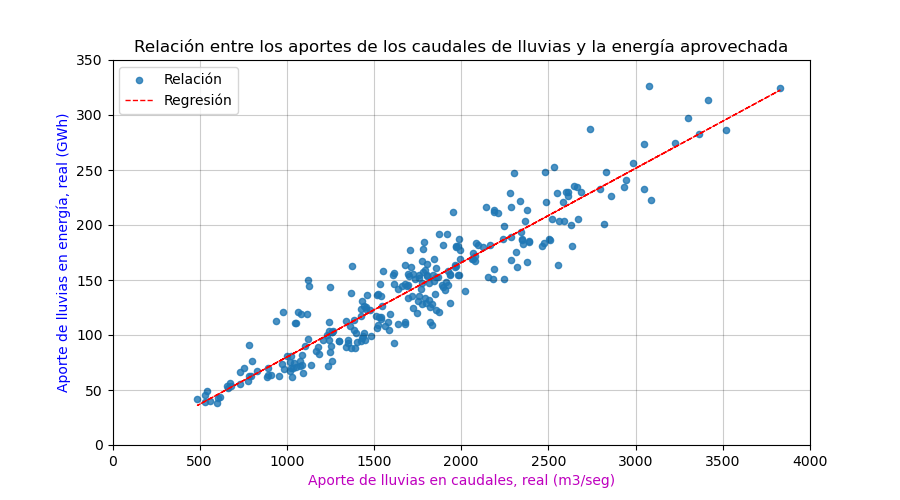

In [205]:
#*******************************************************************************
# 4.2.12. Grafica dispersión de aporCaudalRio Vs aporEner con la regresión.
#*******************************************************************************
fig = plt.figure(figsize=(9,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.

ax1.set_title ('Relación entre los aportes de los caudales de lluvias y la energía aprovechada')

# ax1.set_xlabel("Mes")
# ax1.set_ylabel("Aporte de lluvias en energía, real (GWh)", color='b')
# ax2.set_ylabel("Aporte de lluvias en caudales, real (m3/seg)", color='m')

plt.scatter(aportes_m.aporCaudalRio, aportes_m.aporEner, label='Relación', \
    alpha=0.8, s=20, marker="o")
ax1.plot(aportes_m.aporCaudalRio, aportes_m.aporEner_hat, 'r--', \
    label='Regresión', linewidth=1)
plt.xlabel("Aporte de lluvias en caudales, real (m3/seg)", color='m')
plt.ylabel("Aporte de lluvias en energía, real (GWh)", color='b')
# plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 350)
plt.xlim(0, 4000)
# plt.par.ylim(0, 400)
#plt.set_ylim(0, 350)
# ax2.set_ylim(0, 4500)
plt.legend(loc='best')
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

La relación es: aporEner = (aporCaudalRio * 0.0857) - 5.799 

## 4.3. Relación entre el MEI  y los 'Aportes de caudales de lluvia reales' 

In [24]:
#*******************************************************************************
# 4.3.1. Lee el meiT y aportes_m.
#*******************************************************************************
meiT = pd.read_parquet('parquet/meiT.parquet.gzip', engine='fastparquet')
aportes_m = pd.read_parquet('parquet/aportes_m.parquet.gzip', \
    engine='fastparquet')

In [25]:
#*******************************************************************************
# 4.3.2. Acondiciona meiT para poder comparar relacionar con aportes_m.
#*******************************************************************************
mei_real = meiT.loc[meiT['mei'].notna(), 'mei']
mei_real.index.name = 'Date'
caudal_mei = pd.merge(aportes_m.aporCaudalRio/1e3, mei_real, left_on="Date", right_on="Date")
caudal_mei = pd.merge(caudal_mei, aportes_m.aporCaudalMediHistRio/1e3, left_on="Date", right_on="Date")
# caudal_mei

In [26]:
#*******************************************************************************
# 4.3.3. Corrige valores atípicos de aporCaudalMediHistRio.
#*******************************************************************************
# caudal_mei.loc[pd.to_datetime('2013-05-01'), 'aporCaudalMediHistRio'] #3.41
# caudal_mei.loc[pd.to_datetime('2015-10-01'), 'aporCaudalMediHistRio'] #5.20
# caudal_mei.loc[pd.to_datetime('2015-11-01'), 'aporCaudalMediHistRio'] #5.29
# caudal_mei.loc[pd.to_datetime('2015-12-01'), 'aporCaudalMediHistRio'] #4.07
#
# caudal_mei.loc[pd.to_datetime('2014-05-01'), 'aporCaudalMediHistRio'] #2.13
# caudal_mei.loc[pd.to_datetime('2016-10-01'), 'aporCaudalMediHistRio'] #2.63
# caudal_mei.loc[pd.to_datetime('2016-11-01'), 'aporCaudalMediHistRio'] #2.80
# caudal_mei.loc[pd.to_datetime('2016-12-01'), 'aporCaudalMediHistRio'] #2.05
#
caudal_mei_c = caudal_mei.copy()
caudal_mei_c.loc['2013-05-01', 'aporCaudalMediHistRio'] = \
    caudal_mei_c.loc['2014-05-01', 'aporCaudalMediHistRio']
caudal_mei_c.loc['2015-10-01', 'aporCaudalMediHistRio'] = \
    caudal_mei_c.loc['2016-10-01', 'aporCaudalMediHistRio']
caudal_mei_c.loc['2015-11-01', 'aporCaudalMediHistRio'] = \
    caudal_mei_c.loc['2016-11-01', 'aporCaudalMediHistRio']
caudal_mei_c.loc['2015-12-01', 'aporCaudalMediHistRio'] = \
    caudal_mei_c.loc['2016-12-01', 'aporCaudalMediHistRio']
caudal_mei = caudal_mei_c  

In [27]:
#*******************************************************************************
# 4.3.4. Calcula mei1 (un retardo en el mei).
#*******************************************************************************
caudal_mei.insert(3, column='mei1', value=caudal_mei.mei.shift(), allow_duplicates=True)
caudal_mei = caudal_mei.dropna()

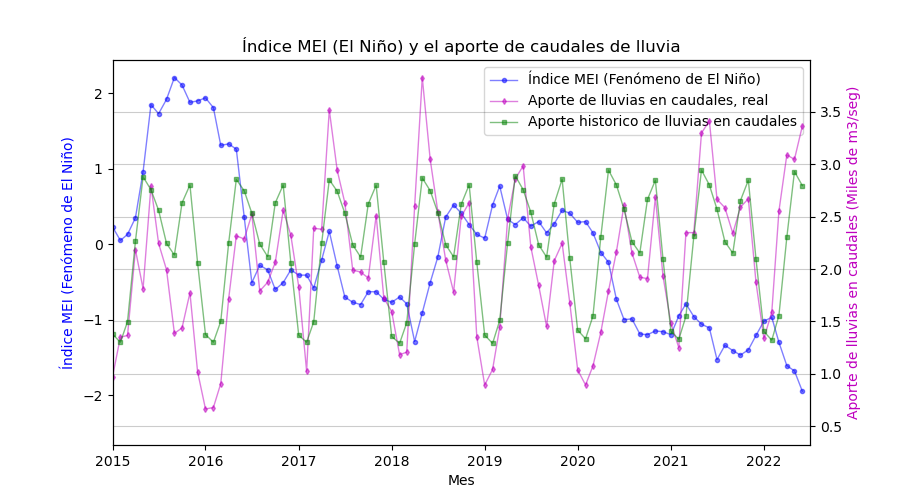

In [81]:
#*******************************************************************************
# 4.3.5. Grafica mei, aportCaudalRio y aporCaudalMediHistRio.
#*******************************************************************************
fig = plt.figure(figsize=(9,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
ax2 = ax1.twinx()

ax1.set_title ("Índice MEI (El Niño) y el aporte de caudales de lluvia")

ax1.set_xlabel("Mes")
ax1.set_ylabel("Índice MEI (Fenómeno de El Niño)", color='b')
ax2.set_ylabel("Aporte de lluvias en caudales (Miles de m3/seg)", color='m')

linea1 = ax1.plot(caudal_mei.index, caudal_mei.mei, 'b-o', \
    label="Índice MEI (Fenómeno de El Niño)", \
        linewidth=1, markersize=3, alpha=0.5)

linea2 = ax2.plot(caudal_mei.index, caudal_mei.aporCaudalRio, 'm-d', \
    label="Aporte de lluvias en caudales, real", linewidth=1, \
        markersize=3, alpha=0.5)

linea3 = ax2.plot(caudal_mei.index, caudal_mei.aporCaudalMediHistRio, 'g-s', \
    label="Aporte historico de lluvias en caudales", linewidth=1, \
        markersize=3, alpha=0.5)

# added these three lines
lineas = linea1 + linea2 + linea3
etiquetas = [l.get_label() for l in lineas]
ax1.legend(lineas, etiquetas, loc='best')

# plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-06-01'))
plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
#plt.ylim(0, 400)
#plt.par.ylim(0, 400)
# ax1.set_ylim(0, 350)
# ax2.set_ylim(0, 4500)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [83]:
#*******************************************************************************
# 4.3.6. Calcula coeficiente de correlación entre mei y aporCaudalRio.
#*******************************************************************************
import scipy.stats
r, p = scipy.stats.pearsonr(caudal_mei.mei, caudal_mei.aporCaudalRio)
#r, p # r (correlación de Pearson): -0.3067; valor p: 0.
#mei: (-0.31433351138495325, 1.3979868319505354e-07)
#mei1: (-0.32745039954951416, 4.075025773408061e-08)
#mei2: (-0.30851561209096595, 2.559915197528141e-07)


In [28]:
#*******************************************************************************
# 4.3.7. Calcula la regresión entre caudal_mei.mei Vs caudal_mei.aporCaudalRio.
#*******************************************************************************
a, b, c = np.polyfit(caudal_mei.mei, caudal_mei.aporCaudalRio, 2) #grado 2.
caudal_mei.insert(4, 'aporCaudalRio_hat',  \
    a * np.square(caudal_mei.mei) + b * caudal_mei.mei + c, allow_duplicates=True) 
# caudal_mei
# a, b, c
# (0.056633704635569736, -0.21706142481276552, 1.6296385955059782)

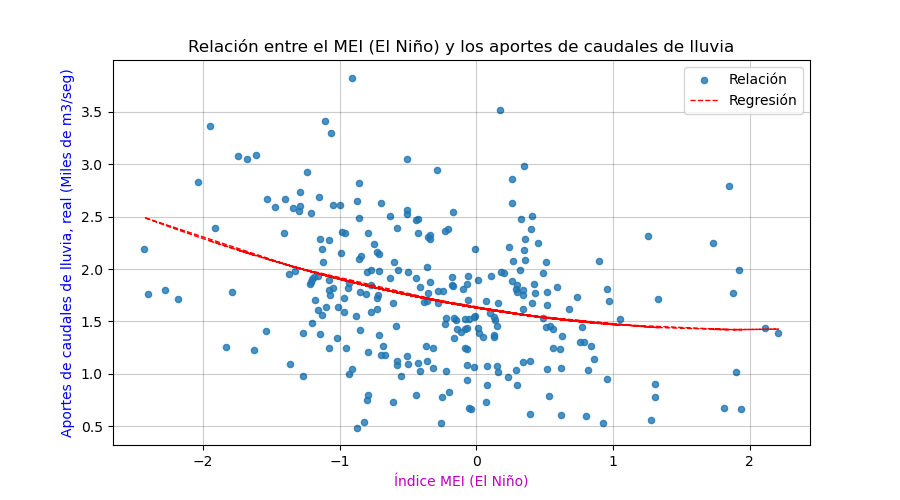

In [85]:
#*******************************************************************************
# 4.3.8. Gráfica de dispersión de mei Vs aporCaudalRio, con la regresión.
#*******************************************************************************
fig = plt.figure(figsize=(9,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.

ax1.set_title ('Relación entre el MEI (El Niño) y los aportes de caudales de lluvia')

# ax1.set_xlabel("Mes")
# ax1.set_ylabel("Aporte de lluvias en energía, real (GWh)", color='b')
# ax2.set_ylabel("Aporte de lluvias en caudales, real (m3/seg)", color='m')

plt.scatter(caudal_mei.mei, caudal_mei.aporCaudalRio, label='Relación', \
    alpha=0.8, s=20, marker="o")
ax1.plot(caudal_mei.mei, caudal_mei.aporCaudalRio_hat, 'r--', \
    label='Regresión', linewidth=1)
plt.xlabel("Índice MEI (El Niño)", color='m')
plt.ylabel("Aportes de caudales de lluvia, real (Miles de m3/seg)", color='b')
# plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
# plt.ylim(0, 350)
# plt.xlim(0, 4000)
# plt.par.ylim(0, 400)
#plt.set_ylim(0, 350)
# ax2.set_ylim(0, 4500)
plt.legend(loc='best')
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

## 4.4. Modelo entre el MEI + 'Aportes de caudales históricos' con los 'Aportes de caudales de lluvia reales' 

In [29]:
#*******************************************************************************
# 4.4.1. Modelo de regresión lineal aporCaudalRio ~ mei + aporCaudalMediHistRio.
#*******************************************************************************
regresion_lineal = smf.ols(formula = 'aporCaudalRio ~ mei + aporCaudalMediHistRio', data=caudal_mei)
modelo_ajustado_caudal = regresion_lineal.fit()
modelo_ajustado_caudal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          aporCaudalRio   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     341.3
Date:                Thu, 11 Aug 2022   Prob (F-statistic):           3.59e-74
Time:                        17:23:17   Log-Likelihood:                -86.508
No. Observations:                 269   AIC:                             179.0
Df Residuals:                     266   BIC:                             189.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0220      0.071      0.308      0.758      -0.118       0.162
mei                      -0.2603      0.024    -10.739      0.000      -0.308      -0.213
aporCaudalMediHistRio     0.9139      0.038     24.267      0.000       0.840       0.988
==============================================================================
Omnibus:                       14.032   Durbin-Watson:                   1.140
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.770
Skew:                           0.474   Prob(JB):                     0.000376
Kurtosis:                       3.713   Cond. No.                         8.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
#*******************************************************************************
# 4.4.2. Salva  y lee el modelo_ajustado_caudal.
#*******************************************************************************
#Salva modelo_ajustado_caudal
# modelo_ajustado_caudal.save('modelos/modelo_ajustado_caudal.pickle')
#Lee modelo_ajustado_caudal
modelo_ajustado_caudal = sm.load('modelos/modelo_ajustado_caudal.pickle')

In [31]:
#*******************************************************************************
# 4.4.3. Matriz de correlación.
#*******************************************************************************
corr = caudal_mei.iloc[:, 0:3].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,aporCaudalRio,mei,aporCaudalMediHistRio
aporCaudalRio,1.00,-0.31,0.77
mei,-0.31,1.00,0.04
aporCaudalMediHistRio,0.77,0.04,1.00


In [32]:
#*******************************************************************************
# 4.4.4. Incluye los valores ajustados de aportes de caudal en caudal_mei.
#*******************************************************************************
valores_ajustados = modelo_ajustado_caudal.predict(caudal_mei)
caudal_mei.insert(loc=4, column='aporCaudal_hat', value=valores_ajustados, allow_duplicates=True)
# caudal_mei

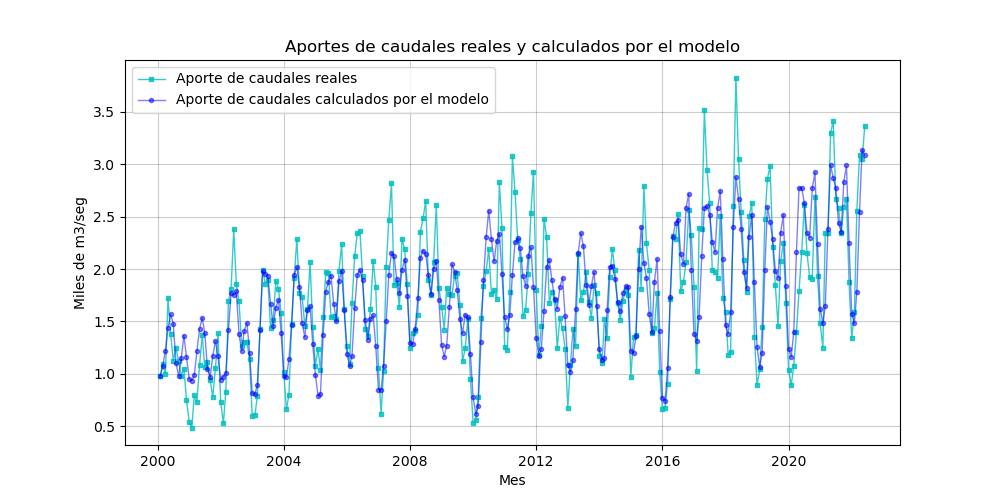

In [15]:
#*******************************************************************************
# 4.4.5. Grafica aporte de caudales reales y ajustados.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de caudales reales y calculados por el modelo')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(caudal_mei.index, caudal_mei.aporCaudalRio, 'c-s', \
    label='Aporte de caudales reales', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(caudal_mei.index, caudal_mei.aporCaudal_hat, 'b-o', \
    label='Aporte de caudales calculados por el modelo', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
#plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2029-01-01'))
# plt.ylim(0, 350)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

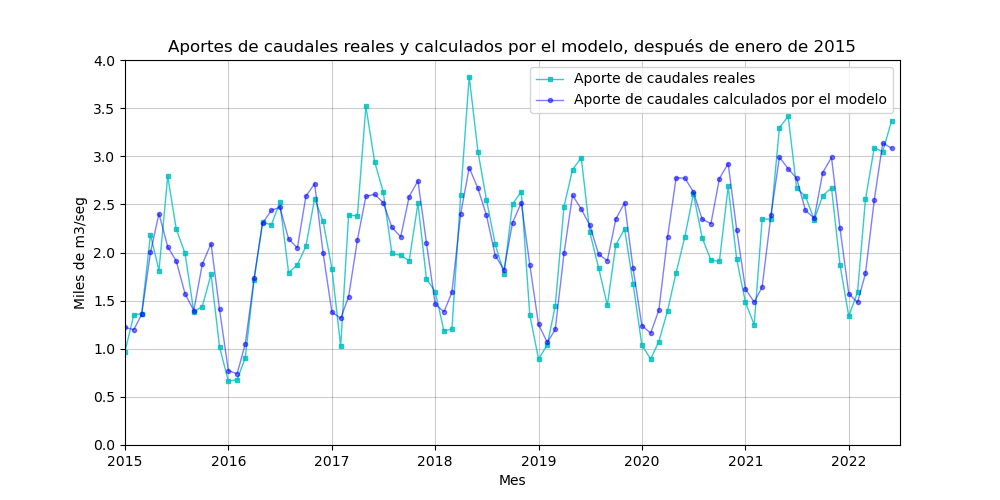

In [16]:
#*******************************************************************************
# 4.4.6. Grafica aporte de caudales reales y ajustados, después de 2015.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de caudales reales y calculados por el modelo, después de enero de 2015')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(caudal_mei.index, caudal_mei.aporCaudalRio, 'c-s', \
    label='Aporte de caudales reales', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(caudal_mei.index, caudal_mei.aporCaudal_hat, 'b-o', \
    label='Aporte de caudales calculados por el modelo', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [33]:
#*******************************************************************************
# 4.4.7. Define el mape.
#*******************************************************************************
#mean_absolute_percentage_error, La media del porcentaje de error absoluto. 
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
#*******************************************************************************
# 4.4.8. Aplica el mape a todo el conjunto de datos.
#*******************************************************************************
mape(caudal_mei.aporCaudalRio, caudal_mei.aporCaudal_hat) #16.38%.

16.38407717086482

In [35]:
#*******************************************************************************
# 4.4.9. Crea caudal_mei_m (para modelo) subconjuntos de train y test.
#*******************************************************************************
caudal_mei_m = caudal_mei.drop(columns=['mei1', 'aporCaudal_hat'], axis=1)

In [37]:
#*******************************************************************************
# 4.4.10. Salva  y lee caudal_mei_m (para el modelo con train y test).
#*******************************************************************************
#Salva caudal_mei_m
# caudal_mei_m.to_parquet('parquet/caudal_mei_m.parquet.gzip', \
#     compression='gzip', engine='fastparquet')
#Lee caudal_mei_m
caudal_mei_m = pd.read_parquet('parquet/caudal_mei_m.parquet.gzip', \
    engine='fastparquet')

In [39]:
#*******************************************************************************
# 4.4.11. Crea subconjuntos de train y test.
#*******************************************************************************
caudal_mei_m = caudal_mei.drop(columns=['aporCaudal_hat'], axis=1)
train = caudal_mei_m.iloc[:-78]
test = caudal_mei_m.iloc[-78:]

In [41]:
#*******************************************************************************
# 4.4.12. Modelo de regresión lineal aplicado a train.
#*******************************************************************************
regresion_lineal = smf.ols(formula = 'aporCaudalRio ~ mei + aporCaudalMediHistRio', data=train)
modelo_ajustado_caudal_t = regresion_lineal.fit()
modelo_ajustado_caudal_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          aporCaudalRio   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     187.4
Date:                Thu, 11 Aug 2022   Prob (F-statistic):           1.70e-45
Time:                        17:29:20   Log-Likelihood:                -45.545
No. Observations:                 191   AIC:                             97.09
Df Residuals:                     188   BIC:                             106.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.0310      0.089     -0.349      0.728      -0.206       0.144
mei                      -0.2641      0.027     -9.802      0.000      -0.317      -0.211
aporCaudalMediHistRio     0.9556      0.052     18.477      0.000       0.854       1.058
==============================================================================
Omnibus:                       13.811   Durbin-Watson:                   1.207
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.377
Skew:                           0.572   Prob(JB):                     0.000458
Kurtosis:                       3.789   Cond. No.                         8.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
#*******************************************************************************
# 4.4.13. Salva  y lee el modelo_ajustado_caudal_t (aplicado a train)
#*******************************************************************************
#Salva modelo_ajustado_caudal_t
# modelo_ajustado_caudal_t.save('modelos/modelo_ajustado_caudal_t.pickle')
#Lee modelo_ajustado_caudal
modelo_ajustado_caudal_t = sm.load('modelos/modelo_ajustado_caudal_t.pickle')

In [43]:
#*******************************************************************************
# 4.4.14. Incluye los valores ajustados de test.
#*******************************************************************************
valores_ajustados = modelo_ajustado_caudal_t.predict(test)
test.insert(loc=3, column='aporCaudal_hat', value=valores_ajustados, allow_duplicates=True)

In [44]:
#*******************************************************************************
# 4.4.15. Calcula el modelo en test.
#*******************************************************************************
mape(test.aporCaudalRio, test.aporCaudal_hat) #16.5%

16.548927941040834

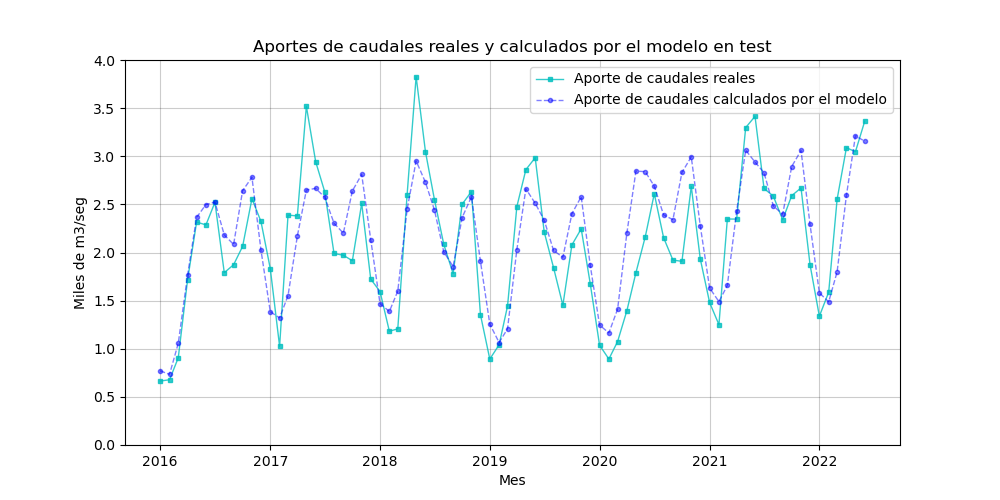

In [45]:
#*******************************************************************************
# 4.4.16. Grafica aporte de caudales reales y calculados por el modelo en test.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de caudales reales y calculados por el modelo en test')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(test.index, test.aporCaudalRio, 'c-s', \
    label='Aporte de caudales reales', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(test.index, test.aporCaudal_hat, 'b--o', \
    label='Aporte de caudales calculados por el modelo', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2015-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

## 4.5. Proyección de los 'Aportes de caudales de lluvia históricos' 

In [2]:
#*******************************************************************************
# 4.5.1. Lee aportes_m.
#*******************************************************************************
#Lee aportes_m
aportes_m = pd.read_parquet('parquet/aportes_m.parquet.gzip', \
    engine='fastparquet')

In [3]:
#*******************************************************************************
# 4.5.2. Crea aportes_h (históricos).
#*******************************************************************************
aportes_h = aportes_m
aportes_h = aportes_h.drop(columns=['aporEner', 'aporEnerMediHist', 'aporCaudalRio', \
    'diferenciaAportes'], axis=1)
aportes_h['aporCaudalMediHistRio'] = aportes_h['aporCaudalMediHistRio']/1e3 

In [5]:
#*******************************************************************************
# 4.5.3. Corrige valores atípicos de aporCaudalMediHistRio.
#*******************************************************************************
# aportes_h.loc[pd.to_datetime('2013-05-01'), 'aporCaudalMediHistRio'] #3.41
# aportes_h.loc[pd.to_datetime('2015-10-01'), 'aporCaudalMediHistRio'] #5.20
# aportes_h.loc[pd.to_datetime('2015-11-01'), 'aporCaudalMediHistRio'] #5.29
# aportes_h.loc[pd.to_datetime('2015-12-01'), 'aporCaudalMediHistRio'] #4.07
#
# aportes_h.loc[pd.to_datetime('2014-05-01'), 'aporCaudalMediHistRio'] #2.13
# aportes_h.loc[pd.to_datetime('2016-10-01'), 'aporCaudalMediHistRio'] #2.63
# aportes_h.loc[pd.to_datetime('2016-11-01'), 'aporCaudalMediHistRio'] #2.80
# aportes_h.loc[pd.to_datetime('2016-12-01'), 'aporCaudalMediHistRio'] #2.05
#
aportes_h_c = aportes_h.copy()
aportes_h_c.loc['2013-05-01', 'aporCaudalMediHistRio'] = \
    aportes_h_c.loc['2014-05-01', 'aporCaudalMediHistRio']
aportes_h_c.loc['2015-10-01', 'aporCaudalMediHistRio'] = \
    aportes_h_c.loc['2016-10-01', 'aporCaudalMediHistRio']
aportes_h_c.loc['2015-11-01', 'aporCaudalMediHistRio'] = \
    aportes_h_c.loc['2016-11-01', 'aporCaudalMediHistRio']
aportes_h_c.loc['2015-12-01', 'aporCaudalMediHistRio'] = \
    aportes_h_c.loc['2016-12-01', 'aporCaudalMediHistRio']
aportes_h = aportes_h_c  

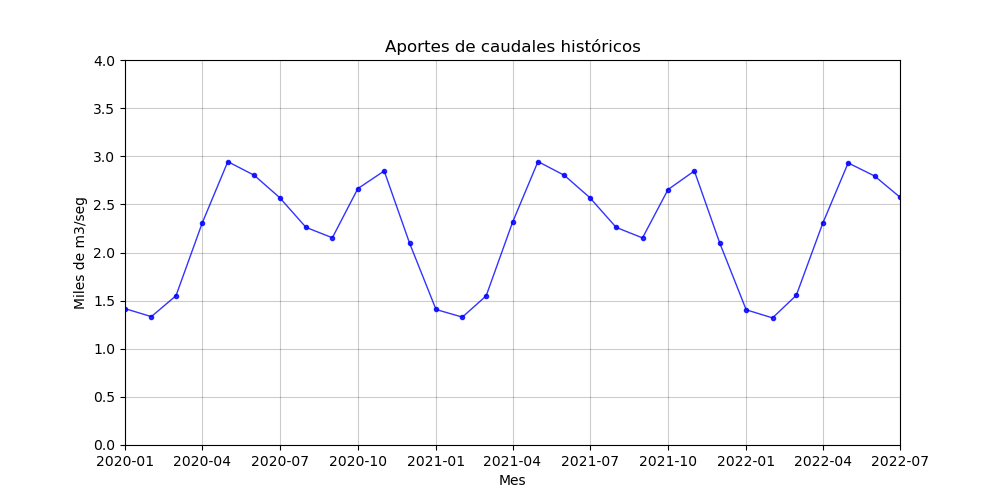

In [6]:
#*******************************************************************************
# 4.5.4. Grafica de aporte de caudales históricos.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de caudales históricos')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_h.index, aportes_h.aporCaudalMediHistRio, 'b-o', \
    label='Aporte de caudales históricos', linewidth=1, markersize=3, alpha=0.8)
# ax1.plot(caudal_mei.index, caudal_mei.aporCaudal_hat, 'b-o', \
#     label='Aporte de caudales calculados por el modelo', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
# ax1.axvspan(pd.to_datetime('2022-06-01'), pd.to_datetime('2029-01-01'), \
#     color='#808080', alpha=0.3)
# plt.legend(loc='best')
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

In [7]:
#*******************************************************************************
# 4.5.5. Crea los aportes futuros de caudales históricos.
#*******************************************************************************
aportes_repetidos = pd.DataFrame(aportes_h.loc['2021-07-01': '2022-06-01', \
    'aporCaudalMediHistRio'].values, index=range(0,12))
aportes_futuros = pd.DataFrame()
for i in range(1, 7):
    aportes_futuros = aportes_futuros.append(aportes_repetidos)
aportes_futuros = aportes_futuros.append(aportes_repetidos[0:6])
aportes_futuros = aportes_futuros.reset_index()
aportes_futuros = aportes_futuros.drop(columns=['index'], axis=1)


In [11]:
#*******************************************************************************
# 4.5.6. Crea DataFrame de proyección.
#*******************************************************************************
aportes_h_py = pd.DataFrame({'aporCaudalMediHistRio': \
    aportes_futuros[0].values}, index=pd.date_range(start='2022-07-01', \
        periods = 78, freq='MS'))
aportes_h_py.index.name = 'Date'


In [16]:
#*******************************************************************************
# 4.5.7. Integra DataFrame de proyección con aportes históricos.
#*******************************************************************************
aportes_h_py = aportes_h_py.rename(columns={'aporCaudalMediHistRio': \
    'aporCaudalHistProy'})
aportes_h = aportes_h.join(aportes_h_py, how='outer')


In [25]:
#*******************************************************************************
# 4.5.8. Salva  y lee aportes_h.
#*******************************************************************************
#Salva aportes_h
# aportes_h.to_parquet('parquet/aportes_h.parquet.gzip', \
#     compression='gzip', engine='fastparquet')
#Lee caudal_mei_m
aportes_h = pd.read_parquet('parquet/aportes_h.parquet.gzip', \
    engine='fastparquet')

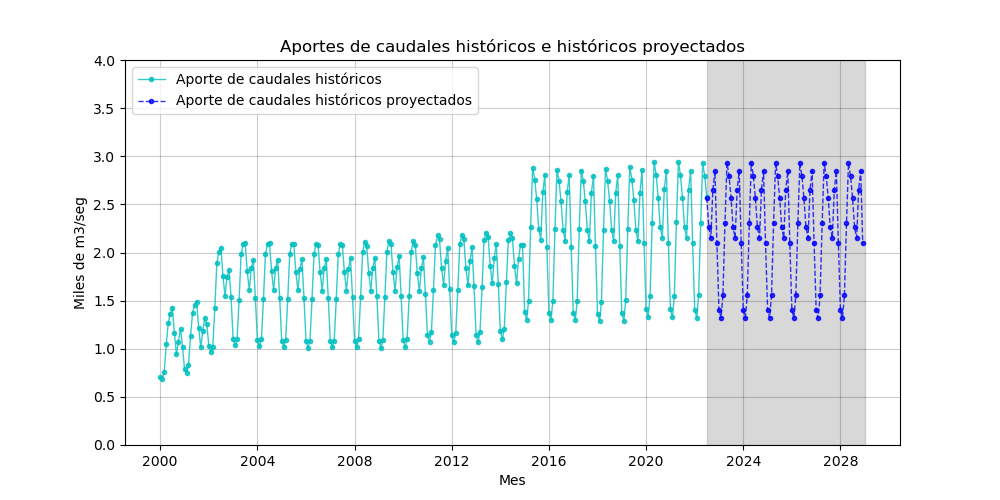

In [26]:
#*******************************************************************************
# 4.5.9. Grafica de aporte de caudales históricos e históricos proyectados.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax1.set_title ('Aportes de caudales históricos e históricos proyectados')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_h.index, aportes_h.aporCaudalMediHistRio, 'c-o', \
    label='Aporte de caudales históricos', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(aportes_h.index, aportes_h.aporCaudalHistProy, 'b--o', \
    label='Aporte de caudales históricos proyectados', linewidth=1, markersize=3, alpha=0.8)
# ax1.plot(caudal_mei.index, caudal_mei.aporCaudal_hat, 'b-o', \
#     label='Aporte de caudales calculados por el modelo', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
    color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

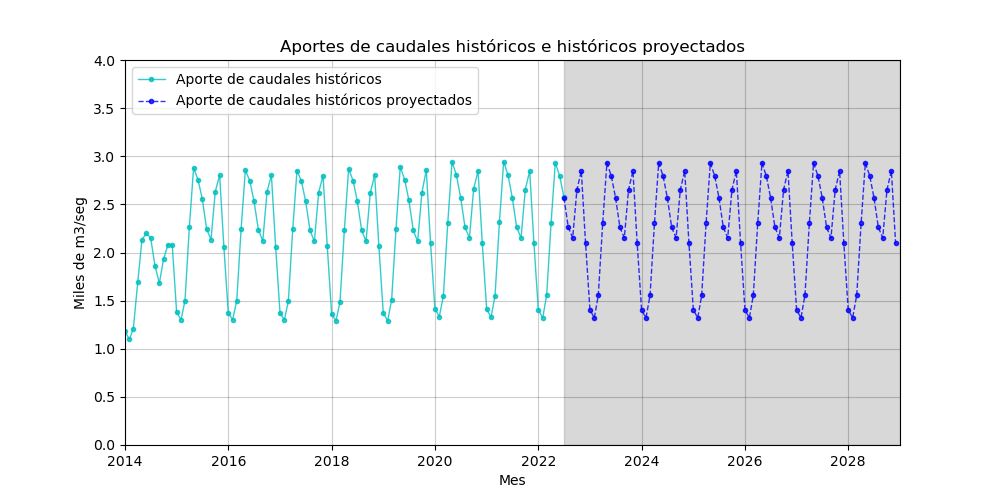

In [27]:
#*******************************************************************************
# 4.5.10. Grafica de caudales históricos y proyectados, desde 2014.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Aportes de caudales históricos e históricos proyectados')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(aportes_h.index, aportes_h.aporCaudalMediHistRio, 'c-o', \
    label='Aporte de caudales históricos', linewidth=1, markersize=3, alpha=0.8)
ax1.plot(aportes_h.index, aportes_h.aporCaudalHistProy, 'b--o', \
    label='Aporte de caudales históricos proyectados', linewidth=1, \
        markersize=3, alpha=0.8)
# ax1.plot(caudal_mei.index, caudal_mei.aporCaudal_hat, 'b-o', \
#     label='Aporte de caudales calculados por el modelo', linewidth=1, markersize=3, alpha=0.5)
# ax1.plot(meiT.index, meiT.meiP1988_08, 'r-', label='Escenario alto', markersize=2)
# ax1.plot(meiT.index, meiT.meiP2010_07, 'y-', label='Escenario Medio', markersize=2)
# ax1.plot(meiT.index, meiT.meiP1998_08, 'g-', label='Escenario Bajo', markersize=2)
ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
    color='#808080', alpha=0.3)
plt.legend(loc='best')
plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

## 4.6. Proyección de los 'Aportes de caudales de lluvias'
La proyección de los aportes de caudales de lluvias se deben hacer para tres escenarios hasta diciembre de 2028.

La variable objetivo es 'aporCaudalRio' y las variables explicativas son: 'mei' y 'aporCaudalMediHistRio'.

La variable 'mei' es la que genera los tres escenarios.

Ya se cuenta con el modelo y se requiera elaborar el nuevo conjunto de datos sobre los que se aplicará la proyección.

In [28]:
#*******************************************************************************
# 4.6.1. Se carga el modelo_ajustado_caudal basado en el conjunto 'train'.
#*******************************************************************************
modelo_ajustado_caudal_t = sm.load('modelos/modelo_ajustado_caudal_t.pickle')

In [163]:
#*******************************************************************************
# 4.6.2. Se leen las variables requeridas para proyectar los aportes de lluvias.
#*******************************************************************************
#Lee el meiT que contiene las proyecciones de mei en tres escenarios.
meiT = pd.read_parquet('parquet/meiT.parquet.gzip', \
    engine='fastparquet')
#Lee el aportes_h que contiene las proyecciones aportes históricos proyectados.
aportes_h = pd.read_parquet('parquet/aportes_h.parquet.gzip', \
    engine='fastparquet')
#Lee el caudal_mei_m que contiene el formato para aplicar al modelo.
caudal_mei_m = pd.read_parquet('parquet/caudal_mei_m.parquet.gzip', \
    engine='fastparquet')



In [164]:
#*******************************************************************************
# 4.6.3. Crea tres escenarios de caudal_mei para proyectar aportes de lluvias.
#*******************************************************************************
aportes_h = aportes_h.drop(columns=['aporCaudalMediHistRio'], axis=1)
caudal_mei_m0 = caudal_mei_m.join(aportes_h, how='right')
caudal_mei_m0['aporCaudalMediHistRio'] = caudal_mei_m0['aporCaudalHistProy']
caudal_mei_m0 = caudal_mei_m0.loc[pd.to_datetime('2022-07-01'):pd.to_datetime('2028-12-01'), \
    ['aporCaudalRio', 'mei', 'aporCaudalMediHistRio']]
meiT = meiT.loc[pd.to_datetime('2022-07-01'):pd.to_datetime('2028-12-01'), \
     ['meiP1988_08', 'meiP1998_08', 'meiP2010_07']]
meiT = meiT.rename(columns={'meiP1988_08': 'EscenarioAlto', \
    'meiP1998_08': 'EscenarioBajo', 'meiP2010_07': 'EscenarioMedio'})
#
caudal_mei_Alto = caudal_mei_m0.copy()
caudal_mei_Medio = caudal_mei_m0.copy()
caudal_mei_Bajo = caudal_mei_m0.copy()
#
caudal_mei_Alto['mei'] = meiT['EscenarioAlto'].values
caudal_mei_Medio['mei'] = meiT['EscenarioMedio'].values
caudal_mei_Bajo['mei'] = meiT['EscenarioBajo'].values


In [186]:
#*******************************************************************************
# 4.6.4. Calcula los valores proyectados en los tres escenarios.
#*******************************************************************************
# valores_ajustados_Alto = modelo_ajustado_caudal_t.predict(caudal_mei_Alto)
# caudal_mei_Alto['aporCaudalRio'] = valores_ajustados_Alto
# caudal_mei_Alto = caudal_mei_Alto.rename(columns={'aporCaudalRio': \
#     'aporCaudalAlto'})

# valores_ajustados_Medio = modelo_ajustado_caudal_t.predict(caudal_mei_Medio)
# caudal_mei_Medio['aporCaudalRio'] = valores_ajustados_Medio
# caudal_mei_Medio = caudal_mei_Medio.rename(columns={'aporCaudalRio': \
#     'aporCaudalMedio'})

# valores_ajustados_Bajo = modelo_ajustado_caudal_t.predict(caudal_mei_Bajo)
# caudal_mei_Bajo['aporCaudalRio'] = valores_ajustados_Bajo
# caudal_mei_Bajo = caudal_mei_Bajo.rename(columns={'aporCaudalRio': \
#     'aporCaudalBajo'})

# caudal_escenarios = caudal_mei_Alto.copy()
# caudal_escenarios = caudal_escenarios.drop(columns=['mei', 'aporCaudalMediHistRio'], axis=1)
# caudal_escenarios.insert(loc=1, column='aporCaudalMedio', \
#     value=caudal_mei_Medio.loc[:, 'aporCaudalMedio'].values)
# caudal_escenarios.insert(loc=2, column='aporCaudalBajo', \
#     value=caudal_mei_Bajo.loc[:, 'aporCaudalBajo'].values)

# caudal_escenarios

In [188]:
#*******************************************************************************
# 4.6.5. Salva  y lee caudal_escenarios.
#*******************************************************************************
#Salva caudal_escenarios
caudal_escenarios.to_parquet('parquet/caudal_escenarios.parquet.gzip', \
    compression='gzip', engine='fastparquet')
#Lee caudal_escenarios
caudal_escenarios = pd.read_parquet('parquet/caudal_escenarios.parquet.gzip', \
    engine='fastparquet')

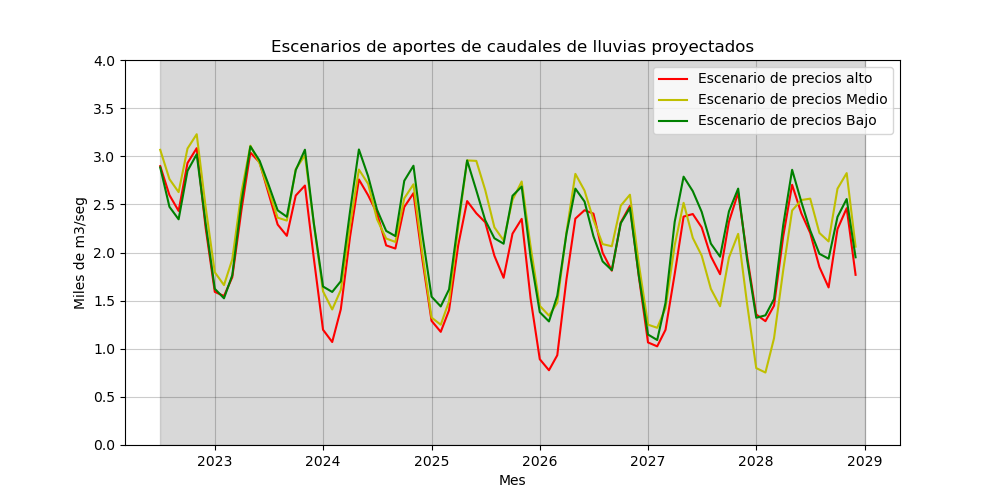

In [190]:
#*******************************************************************************
# 4.6.6. Grafica de caudales de lluvias proyectados, en tres escenarios.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Escenarios de aportes de caudales de lluvias proyectados')
ax1.set_ylabel ('Miles de m3/seg')
ax1.set_xlabel ('Mes')
ax1.plot(caudal_escenarios.index, caudal_escenarios.aporCaudalAlto, 'r-', \
    label='Escenario de precios alto', markersize=2)
ax1.plot(caudal_escenarios.index, caudal_escenarios.aporCaudalMedio, 'y-', \
    label='Escenario de precios Medio', markersize=2)
ax1.plot(caudal_escenarios.index, caudal_escenarios.aporCaudalBajo, 'g-', \
    label='Escenario de precios Bajo', markersize=2)
ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
    color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 4)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

## 4.7. Proyección de los 'Aportes de lluvias en energía'
Ya se cuenta con el factor de conversión y es aporEner = (aporCaudalRio * 0.0857) - 5.799

In [217]:
#*******************************************************************************
# 4.7.1. Crea aporte_energia_escenarios, en tres escenarios.
#*******************************************************************************
aporte_energia_escenarios = caudal_escenarios.copy()

aporte_energia_escenarios.insert(loc=3, column='aporteEnergiaAlto', \
    value=(aporte_energia_escenarios.aporCaudalAlto * 1e3 * 0.0857) - 5.799, \
        allow_duplicates=True)

aporte_energia_escenarios.insert(loc=4, column='aporteEnergiaMedio', \
    value=(aporte_energia_escenarios.aporCaudalMedio * 1e3 * 0.0857) - 5.799, \
        allow_duplicates=True)

aporte_energia_escenarios.insert(loc=5, column='aporteEnergiaBajo', \
    value=(aporte_energia_escenarios.aporCaudalBajo * 1e3 * 0.0857) - 5.799, \
        allow_duplicates=True)

In [220]:
#*******************************************************************************
# 4.7.2. Solo deja escenarios de aporte_energia, elimina caudales.
#*******************************************************************************
aporte_energia_escenarios = aporte_energia_escenarios.drop(columns=['aporCaudalAlto', 'aporCaudalMedio', \
    'aporCaudalBajo'], axis=1)

In [222]:
#*******************************************************************************
# 4.7.3. Salva  y lee aporte_energia_escenarios.
#*******************************************************************************
#Salva aporte_energia_escenarios
# aporte_energia_escenarios.to_parquet\
#     ('parquet/aporte_energia_escenarios.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
#Lee aporte_energia_escenarios
aporte_energia_escenarios = pd.read_parquet\
    ('parquet/aporte_energia_escenarios.parquet.gzip', engine='fastparquet')

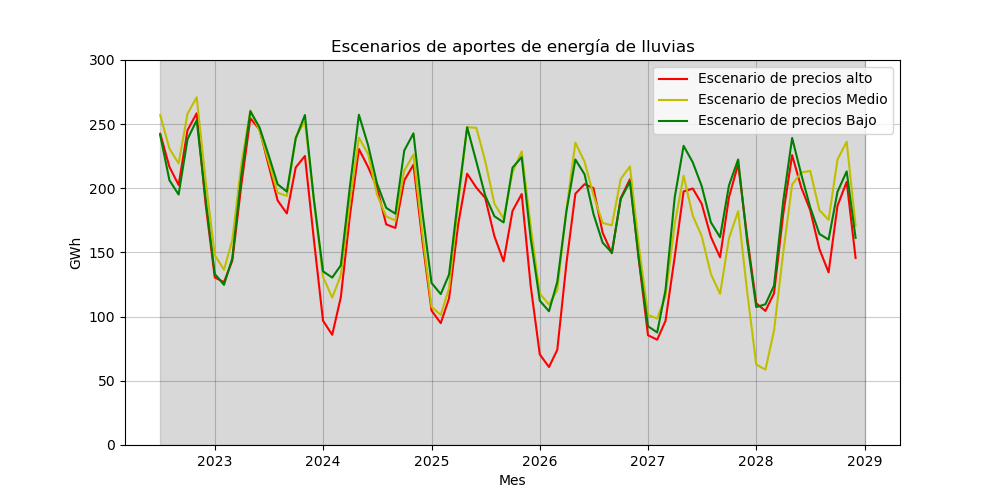

In [225]:
#*******************************************************************************
# 4.7.4. Grafica los aportes de energía de lluvias en tres escenarios.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Escenarios de aportes de energía de lluvias')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaAlto, 'r-', \
    label='Escenario de precios alto', markersize=2)
ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaMedio, 'y-', \
    label='Escenario de precios Medio', markersize=2)
ax1.plot(aporte_energia_escenarios.index, aporte_energia_escenarios.aporteEnergiaBajo, 'g-', \
    label='Escenario de precios Bajo', markersize=2)
ax1.axvspan(pd.to_datetime('2022-07-01'), pd.to_datetime('2029-01-01'), \
    color='#808080', alpha=0.3)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2029-01-01'))
plt.ylim(0, 300)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()